# Kontur-test

### Задача: Классификация новостных заголовков на реальные и ложные.

Импортируем необходимые библиотеки.

In [1]:
from keras.layers import Embedding, LSTM, GRU, Dense, SpatialDropout1D
from natasha import (
    Segmenter,
    MorphVocab,

    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,

    PER,
    NamesExtractor,

    Doc
)
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.initializers import Constant
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import string
import gensim
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")
nltk.download('punkt')


plt.style.use('ggplot')


russian_stopwords = stopwords.words("russian")
pd.options.display.max_colwidth = 1


segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)
names_extractor = NamesExtractor(morph_vocab)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\George\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\George\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Посмотрим на данные.  

In [2]:
# уже размеченные данные
train = pd.read_csv('train.tsv', sep='\t')

# данные, которые нужно будет разметить
test = pd.read_csv('test.tsv', sep='\t')

train.head()

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы,1
1,Агент Кокорина назвал езду по встречке житейской историей,0
2,Госдума рассмотрит возможность введения секретных статей Уголовного кодекса,1
3,ФАС заблокировала поставку скоростных трамваев для Москвы,0
4,Против Навального завели дело о недоносительстве на Волкова,1


1 - фейковая новость  
0 - реальная новость

Посмотрим на накоторые настоящие новостные заголовки

In [3]:
train[train.is_fake == 0].head(10)

,title,is_fake
1,Агент Кокорина назвал езду по встречке житейской историей,0
3,ФАС заблокировала поставку скоростных трамваев для Москвы,0
7,Россияне обхитрили рост цен,0
8,Звезда «Ворониных» раскрыл подробности о своем состоянии,0
9,Microsoft объявила дату выхода очков дополненной реальности Hololens,0
13,Топилин провозгласил окончание зарплатного кризиса в России,0
14,Режиссера Алексея Германа наградили орденом,0
18,Энтони Андерсон стал молодым папашей,0
20,Ubisoft анонсировала новую часть игры Ghost Recon,0
21,На Байконуре сломали малайзийский спутник,0


Теперь на фейковые.

In [4]:
train[train.is_fake == 1].head(10)

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы,1
2,Госдума рассмотрит возможность введения секретных статей Уголовного кодекса,1
4,Против Навального завели дело о недоносительстве на Волкова,1
5,Российским студентам запретят учиться за рубежом,1
6,Путин пишет книгу об истории Украины,1
10,Марат Хуснуллин призвал прописать в законе понятие многонационального дома,1
11,Для проведения профилактических работ с 15 по 19 сентября в России отключат интернет,1
12,В России введут обязательный техосмотр садового инвентаря,1
15,"Олаф Шольц: «Дед рассказывал, какие вкусные на Украине куры, молоко и яйца»",1
16,"Беглов: «Петербург был основан до нашей эры, он на полторы тысячи лет старше Москвы»",1


In [5]:
train.shape

(5758, 2)

In [6]:
test.shape

(1000, 2)

Посмотрим на количество примеров класса 0 и 1 в данных

In [7]:
train.is_fake.value_counts()

1    2879
0    2879
Name: is_fake, dtype: int64

Для дальнейшего анализа объеденим train и test

In [8]:
df = pd.concat([train, test])

#### Посмотрим какие стоп-слова встречаются в данных.

In [9]:
def create_corpus(data):
    """Функция, которая создает массив всех слов в датафрейме"""
    words = []
    for x in df['title'].str.split():
        for i in x:
            words.append(i)
    return words

In [10]:
corpus = create_corpus(df)
dic = defaultdict(int)

for word in corpus:
    if word in russian_stopwords:
        dic[word] += 1

top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:30]

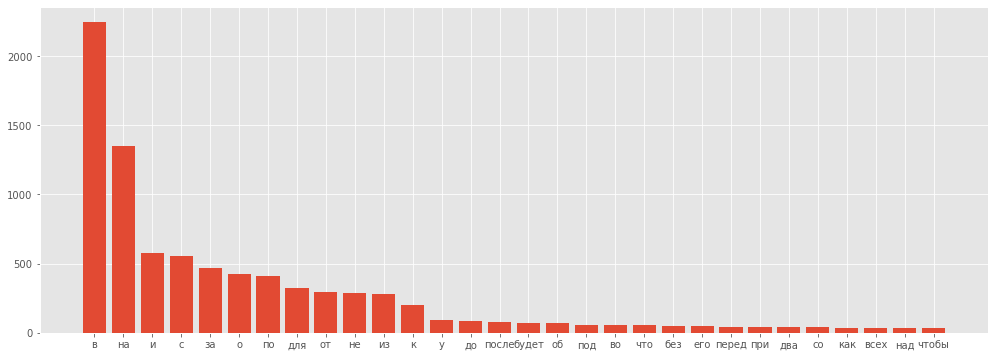

In [11]:
x, y = zip(*top)

fig, ax = plt.subplots()

ax.bar(x, y)

fig.set_figwidth(17)  # ширина Figure
fig.set_figheight(6)  # высота Figure

plt.show()

Посмотрим какие знаки пунктуации содержатся в данных

In [12]:
plt.figure(figsize=(10, 5))
corpus = create_corpus(df)

dic = defaultdict(int)
special = string.punctuation + "»" + '«' + "°"
for i in range(len(corpus)):
    for punkt in special:
        if punkt in corpus[i]:
            dic[punkt] += 1

<Figure size 720x360 with 0 Axes>

<BarContainer object of 21 artists>

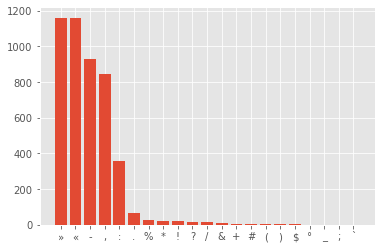

In [13]:
top = sorted(dic.items(), key=lambda x: x[1], reverse=True)
x, y = zip(*top)
plt.bar(x, y)

In [14]:
def remove_punct(line):
    spatial = string.punctuation + "»" + '«' + "°"
    for p in spatial:
        if p in line:
            if (p == '-' or p == '°') and len(line) > 1:
                line = line.replace(p, ' ')
            else:
                line = line.replace(p, '')
    return line

In [15]:
remove_punct("Hello!$@-world«!»")

'Hello world'

## Предобработка. Этап 1.
### Первичная предобработка будет содержать следующие пункты:  
1) Приведение текста к нижнему регистру  
2) Удаление пунктуации  
3) Удаление стоп-слов  

In [16]:
def preprocess(data):
    """data должен иметь тип  pandas.core.frame.DataFrame"""

    # удаление пунктуации
    data['title'] = data['title'].apply(lambda x: remove_punct(x))

    # удаление стоп-слов, цифр, привидение к нижнему регистру
    corpus = []
    for train in tqdm(data['title']):
        words = [word.lower() for word in word_tokenize(train)
                 if ((word.isalpha() == 1) and (word not in russian_stopwords) and (len(word) > 3))]
        corpus.append(words)
    return corpus

Посчитаем максимальную длинну заголовка

In [17]:
corpus = preprocess(df)

100%|██████████| 6758/6758 [00:01<00:00, 6241.96it/s]


In [18]:
corpus[0]

['москвичу',
 'владимиру',
 'клутину',
 'пришёл',
 'счёт',
 'вмешательство',
 'американские',
 'выборы']

In [19]:
MAX_LEN = 0
for i in range(len(corpus)):
    if len(corpus[i]) > MAX_LEN:
        MAX_LEN = len(corpus[i])
print("Максимальная длинна заголовка = ", MAX_LEN)

Максимальная длинна заголовка =  20


Построим гистограмму количеств слов в фейковых заголовках.

In [20]:
corpus = preprocess(train)

100%|██████████| 5758/5758 [00:00<00:00, 7290.13it/s]


In [21]:
dic_false = defaultdict(int)

for i in range(len(corpus)):
    if train['is_fake'][i] == 1:
        dic_false[len(corpus[i])] += 1

<BarContainer object of 21 artists>

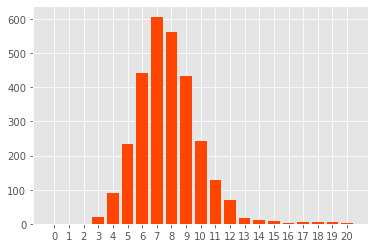

In [22]:
x = []
y = []
for i in range(MAX_LEN+1):
    x.append(str(i))
    y.append(dic_false[i])
plt.bar(x, y, color = '#FF4500')

Построим гистограмму количеств слов в правдивых заголовках.

In [23]:
dic_true = defaultdict(int)

for i in range(len(corpus)):
    if train['is_fake'][i] == 0:
        dic_true[len(corpus[i])] += 1

<BarContainer object of 21 artists>

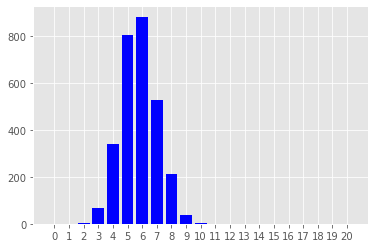

In [24]:
x = []
y = []
for i in range(MAX_LEN+1):
    x.append(str(i))
    y.append(dic_true[i])
plt.bar(x, y, color = '#0000FF')

Теперь совместим две гистограммы.

<BarContainer object of 21 artists>

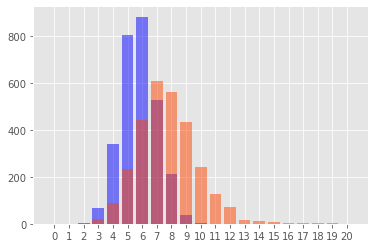

In [25]:
x = []
y_true = []
y_false = []
for i in range(MAX_LEN+1):
    x.append(str(i))
    y_true.append(dic_true[i])
    y_false.append(dic_false[i])
plt.bar(x, y_true, alpha = 0.5, color = '#0000FF')
plt.bar(x, y_false, alpha = 0.5, color = '#FF4500')

В правдивых заголовках количество слов в среднем меньше, поэтому имеет смысл добавить длинну предложения в качестве признака.

Оценим кол-во знакомых слов.

In [26]:
corpus_known = []
corpus_unknown = []

for i in range(len(corpus)):
    for word in corpus[i]:
        if word in emb:
            corpus_known.append(word)
        else:
            if word[0:-1:1] in emb:
                corpus_known.append(word[0:-1:1])
            elif word[0:-2:1] in emb:
                corpus_known.append(word[0:-2:1])
            else:
                corpus_unknown.append(word)

unknown = len(set(corpus_unknown))
print("Количество знакомых слов: ", len(set(corpus_known)))
print("Количество незнакомых слов: ", len(set(corpus_unknown)))

Количество знакомых слов:  16870
Количество незнакомых слов:  997


Теперь попробуем поставить слова в начальную форму, используя библиотеку наташа


In [27]:
df.index = np.arange(len(df))

for i in range(len(corpus_unknown)):
    corpus_unknown[i] = Doc(corpus_unknown[i])

corpus_lemms = []

for i in range(len(corpus_unknown)):
    corpus_unknown[i].segment(segmenter)
    corpus_unknown[i].tag_morph(morph_tagger)
    corpus_unknown[i].tokens[0].lemmatize(morph_vocab)
    corpus_lemms.append(corpus_unknown[i].tokens[0].lemma)

    
known = 0
for i in range(len(corpus_lemms)):
    if corpus_lemms[i] in emb:
        known += 1
        corpus_known.append(corpus_lemms[i])
    elif corpus_lemms[i][0:-1:1] in emb:
        known += 1
        corpus_known.append(corpus_lemms[i][0:-1:1])
    elif corpus_lemms[i][0:-2:1] in emb:
        known += 1
        corpus_known.append(corpus_lemms[i][0:-2:1])
                            
print("Итоговое кол-во незнакомых слов: ", unknown - known)
print("Итоговое кол-во знакомых слов: ", len(set(corpus_known)) + known)

Итоговое кол-во незнакомых слов:  700
Итоговое кол-во знакомых слов:  17386


## Препроцессинг. Этап 2.

1) Создание матрицы эмбедингов  
2) Добавление длинны предложения как признака   
  
  
В планах:  
1)Добавить максимальную разность норм слов как признак  
2)Выкинуть предложения, где много неизвестных слов (>50%)

In [42]:
def generate_pad_word_index(data, max_len):
    corpus = preprocess(data)

    tokenizer_obj = Tokenizer()
    tokenizer_obj.fit_on_texts(corpus)
    sequences = tokenizer_obj.texts_to_sequences(corpus)

    pad = pad_sequences(sequences, maxlen = max_len,
                        truncating = 'post', padding = 'post')            
    return pad, tokenizer_obj.word_index

In [43]:
def create_emb_cnt_words(data, MAX_LEN):
    padding, word_index = generate_pad_word_index(data, MAX_LEN)

    num_words = len(word_index)+1
    embedding = np.zeros((num_words, 300))

    for word, i in tqdm(word_index.items()):
        if i > num_words:
            continue

        if word in emb:
            embedding[i] = emb[word]
        elif word[0:-1:1] in emb:
            embedding[i] = emb[word[0:-1:1]]
        elif word[0:-2:1] in emb:
            embedding[i] = emb[word[0:-2:1]]
        else:
            word = Doc(word)
            word.segment(segmenter)
            word.tag_morph(morph_tagger)
            word.tokens[0].lemmatize(morph_vocab)
            if word.tokens[0].lemma in emb:
                embedding[i] = emb[word.tokens[0].lemma]
            elif word.tokens[0].lemma[0:-1:1] in emb:
                embedding[i] = emb[word.tokens[0].lemma[0:-1:1]]
            elif word.tokens[0].lemma[0:-2:1] in emb:
                embedding[i] = emb[word.tokens[0].lemma[0:-2:1]]
            else:
                embedding[i] = emb['<unk>']

    return embedding, num_words

In [44]:
model = Sequential()
embedding_matrix, cnt_words = create_emb_cnt_words(train, 20)

embedding = Embedding(cnt_words, 300, embeddings_initializer=Constant(embedding_matrix),
                      input_length=MAX_LEN, trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2,
          kernel_initializer='glorot_uniform'))
model.add(Dense(1, activation='sigmoid'))


optimzer = Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',
              optimizer=optimzer, metrics=['accuracy'])

100%|██████████| 17932/17932 [00:01<00:00, 14620.60it/s]


In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 300)           5379900   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 20, 300)          0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 64)                93440     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,473,405
Trainable params: 93,505
Non-trainable params: 5,379,900
_________________________________________________________________


In [46]:
pad, num = generate_pad_word_index(train, MAX_LEN)

100%|██████████| 5758/5758 [00:00<00:00, 5806.69it/s]


In [48]:
X_train, X_test, y_train, y_test = train_test_split(pad ,train['is_fake'].values, test_size=0.2)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (4606, 20)
Shape of Validation  (1152, 20)


In [49]:
history=model.fit(X_train,y_train,batch_size=5,epochs=1,validation_data=(X_test,y_test),verbose=2)

922/922 - 15s - loss: 0.6910 - accuracy: 0.5504 - val_loss: 0.6877 - val_accuracy: 0.6024 - 15s/epoch - 16ms/step


In [59]:
history = model.fit(X_train, y_train, batch_size=15, epochs=500,
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/500
308/308 [==============================] - 5s 15ms/step - loss: 0.2159 - accuracy: 0.9123 - val_loss: 0.2932 - val_accuracy: 0.8785
Epoch 2/500
308/308 [==============================] - 5s 16ms/step - loss: 0.2114 - accuracy: 0.9171 - val_loss: 0.2935 - val_accuracy: 0.8767
Epoch 3/500
308/308 [==============================] - 5s 15ms/step - loss: 0.2176 - accuracy: 0.9138 - val_loss: 0.2928 - val_accuracy: 0.8759
Epoch 4/500
308/308 [==============================] - 5s 16ms/step - loss: 0.2231 - accuracy: 0.9097 - val_loss: 0.2918 - val_accuracy: 0.8759
Epoch 5/500
308/308 [==============================] - 5s 15ms/step - loss: 0.2203 - accuracy: 0.9127 - val_loss: 0.2911 - val_accuracy: 0.8802
Epoch 6/500
308/308 [==============================] - 5s 18ms/step - loss: 0.2168 - accuracy: 0.9134 - val_loss: 0.2929 - val_accuracy: 0.8750
Epoch 7/500
308/308 [==============================] - 5s 16ms/step - loss: 0.2181 - accuracy: 0.9075 - val_loss: 0.2922 - val_accuracy:

308/308 [==============================] - 6s 18ms/step - loss: 0.1798 - accuracy: 0.9266 - val_loss: 0.2965 - val_accuracy: 0.8776
Epoch 58/500
308/308 [==============================] - 6s 18ms/step - loss: 0.1741 - accuracy: 0.9331 - val_loss: 0.2976 - val_accuracy: 0.8750
Epoch 59/500
308/308 [==============================] - 6s 19ms/step - loss: 0.1760 - accuracy: 0.9301 - val_loss: 0.2979 - val_accuracy: 0.8776
Epoch 60/500
308/308 [==============================] - 6s 19ms/step - loss: 0.1924 - accuracy: 0.9212 - val_loss: 0.2957 - val_accuracy: 0.8759
Epoch 61/500
308/308 [==============================] - 5s 17ms/step - loss: 0.1769 - accuracy: 0.9305 - val_loss: 0.2955 - val_accuracy: 0.8733
Epoch 62/500
308/308 [==============================] - 5s 17ms/step - loss: 0.1818 - accuracy: 0.9271 - val_loss: 0.2965 - val_accuracy: 0.8776
Epoch 63/500
308/308 [==============================] - 6s 18ms/step - loss: 0.1754 - accuracy: 0.9297 - val_loss: 0.2970 - val_accuracy: 0.877

308/308 [==============================] - 5s 17ms/step - loss: 0.1494 - accuracy: 0.9412 - val_loss: 0.3027 - val_accuracy: 0.8828
Epoch 114/500
308/308 [==============================] - 5s 17ms/step - loss: 0.1549 - accuracy: 0.9401 - val_loss: 0.3000 - val_accuracy: 0.8819
Epoch 115/500
308/308 [==============================] - 6s 20ms/step - loss: 0.1579 - accuracy: 0.9373 - val_loss: 0.2990 - val_accuracy: 0.8828
Epoch 116/500
308/308 [==============================] - 6s 19ms/step - loss: 0.1503 - accuracy: 0.9394 - val_loss: 0.2997 - val_accuracy: 0.8837
Epoch 117/500
308/308 [==============================] - 5s 18ms/step - loss: 0.1464 - accuracy: 0.9431 - val_loss: 0.3004 - val_accuracy: 0.8819
Epoch 118/500
308/308 [==============================] - 6s 19ms/step - loss: 0.1448 - accuracy: 0.9438 - val_loss: 0.3043 - val_accuracy: 0.8819
Epoch 119/500
308/308 [==============================] - 6s 19ms/step - loss: 0.1541 - accuracy: 0.9405 - val_loss: 0.3022 - val_accuracy:

308/308 [==============================] - 6s 18ms/step - loss: 0.1314 - accuracy: 0.9496 - val_loss: 0.3132 - val_accuracy: 0.8819
Epoch 170/500
308/308 [==============================] - 5s 18ms/step - loss: 0.1342 - accuracy: 0.9514 - val_loss: 0.3127 - val_accuracy: 0.8837
Epoch 171/500
308/308 [==============================] - 6s 20ms/step - loss: 0.1462 - accuracy: 0.9409 - val_loss: 0.3115 - val_accuracy: 0.8828
Epoch 172/500
308/308 [==============================] - 6s 21ms/step - loss: 0.1409 - accuracy: 0.9436 - val_loss: 0.3118 - val_accuracy: 0.8863
Epoch 173/500
308/308 [==============================] - 6s 19ms/step - loss: 0.1365 - accuracy: 0.9468 - val_loss: 0.3104 - val_accuracy: 0.8837
Epoch 174/500
308/308 [==============================] - 5s 17ms/step - loss: 0.1270 - accuracy: 0.9492 - val_loss: 0.3097 - val_accuracy: 0.8837
Epoch 175/500
308/308 [==============================] - 5s 17ms/step - loss: 0.1267 - accuracy: 0.9529 - val_loss: 0.3093 - val_accuracy:

308/308 [==============================] - 5s 16ms/step - loss: 0.1260 - accuracy: 0.9496 - val_loss: 0.3159 - val_accuracy: 0.8837
Epoch 226/500
308/308 [==============================] - 5s 16ms/step - loss: 0.1175 - accuracy: 0.9540 - val_loss: 0.3152 - val_accuracy: 0.8845
Epoch 227/500
308/308 [==============================] - 5s 16ms/step - loss: 0.1116 - accuracy: 0.9557 - val_loss: 0.3178 - val_accuracy: 0.8863
Epoch 228/500
308/308 [==============================] - 5s 18ms/step - loss: 0.1171 - accuracy: 0.9527 - val_loss: 0.3185 - val_accuracy: 0.8854
Epoch 229/500
308/308 [==============================] - 6s 19ms/step - loss: 0.1175 - accuracy: 0.9531 - val_loss: 0.3178 - val_accuracy: 0.8837
Epoch 230/500
308/308 [==============================] - 5s 16ms/step - loss: 0.1145 - accuracy: 0.9574 - val_loss: 0.3183 - val_accuracy: 0.8828
Epoch 231/500
308/308 [==============================] - 5s 16ms/step - loss: 0.1180 - accuracy: 0.9522 - val_loss: 0.3185 - val_accuracy:

308/308 [==============================] - 5s 16ms/step - loss: 0.0960 - accuracy: 0.9650 - val_loss: 0.3322 - val_accuracy: 0.8854
Epoch 282/500
308/308 [==============================] - 5s 16ms/step - loss: 0.1045 - accuracy: 0.9548 - val_loss: 0.3330 - val_accuracy: 0.8837
Epoch 283/500
308/308 [==============================] - 5s 17ms/step - loss: 0.0989 - accuracy: 0.9601 - val_loss: 0.3327 - val_accuracy: 0.8845
Epoch 284/500
308/308 [==============================] - 5s 16ms/step - loss: 0.1056 - accuracy: 0.9579 - val_loss: 0.3292 - val_accuracy: 0.8837
Epoch 285/500
308/308 [==============================] - 5s 16ms/step - loss: 0.0978 - accuracy: 0.9611 - val_loss: 0.3283 - val_accuracy: 0.8837
Epoch 286/500
308/308 [==============================] - 5s 17ms/step - loss: 0.0928 - accuracy: 0.9670 - val_loss: 0.3331 - val_accuracy: 0.8854
Epoch 287/500
308/308 [==============================] - 5s 16ms/step - loss: 0.0979 - accuracy: 0.9640 - val_loss: 0.3328 - val_accuracy:

308/308 [==============================] - 5s 17ms/step - loss: 0.0833 - accuracy: 0.9687 - val_loss: 0.3417 - val_accuracy: 0.8837
Epoch 338/500
308/308 [==============================] - 5s 16ms/step - loss: 0.0845 - accuracy: 0.9681 - val_loss: 0.3422 - val_accuracy: 0.8880
Epoch 339/500
308/308 [==============================] - 5s 16ms/step - loss: 0.0965 - accuracy: 0.9640 - val_loss: 0.3386 - val_accuracy: 0.8854
Epoch 340/500
308/308 [==============================] - 5s 16ms/step - loss: 0.0878 - accuracy: 0.9631 - val_loss: 0.3386 - val_accuracy: 0.8845
Epoch 341/500
308/308 [==============================] - 5s 16ms/step - loss: 0.0916 - accuracy: 0.9637 - val_loss: 0.3390 - val_accuracy: 0.8880
Epoch 342/500
308/308 [==============================] - 5s 16ms/step - loss: 0.0900 - accuracy: 0.9657 - val_loss: 0.3437 - val_accuracy: 0.8837
Epoch 343/500
308/308 [==============================] - 5s 16ms/step - loss: 0.0847 - accuracy: 0.9670 - val_loss: 0.3474 - val_accuracy:

308/308 [==============================] - 8s 26ms/step - loss: 0.0723 - accuracy: 0.9707 - val_loss: 0.3541 - val_accuracy: 0.8828
Epoch 394/500
308/308 [==============================] - 7s 23ms/step - loss: 0.0816 - accuracy: 0.9670 - val_loss: 0.3567 - val_accuracy: 0.8837
Epoch 395/500
308/308 [==============================] - 7s 22ms/step - loss: 0.0701 - accuracy: 0.9737 - val_loss: 0.3523 - val_accuracy: 0.8863
Epoch 396/500
308/308 [==============================] - 7s 23ms/step - loss: 0.0811 - accuracy: 0.9690 - val_loss: 0.3540 - val_accuracy: 0.8811
Epoch 397/500
308/308 [==============================] - 7s 22ms/step - loss: 0.0747 - accuracy: 0.9703 - val_loss: 0.3607 - val_accuracy: 0.8837
Epoch 398/500
308/308 [==============================] - 7s 21ms/step - loss: 0.0683 - accuracy: 0.9742 - val_loss: 0.3588 - val_accuracy: 0.8889
Epoch 399/500
308/308 [==============================] - 7s 23ms/step - loss: 0.0790 - accuracy: 0.9718 - val_loss: 0.3598 - val_accuracy:

308/308 [==============================] - 5s 17ms/step - loss: 0.0672 - accuracy: 0.9755 - val_loss: 0.3691 - val_accuracy: 0.8854
Epoch 450/500
308/308 [==============================] - 5s 17ms/step - loss: 0.0672 - accuracy: 0.9761 - val_loss: 0.3723 - val_accuracy: 0.8837
Epoch 451/500
308/308 [==============================] - 7s 22ms/step - loss: 0.0675 - accuracy: 0.9729 - val_loss: 0.3724 - val_accuracy: 0.8828
Epoch 452/500
308/308 [==============================] - 7s 22ms/step - loss: 0.0643 - accuracy: 0.9770 - val_loss: 0.3724 - val_accuracy: 0.8854
Epoch 453/500
308/308 [==============================] - 7s 23ms/step - loss: 0.0747 - accuracy: 0.9709 - val_loss: 0.3685 - val_accuracy: 0.8854
Epoch 454/500
308/308 [==============================] - 6s 19ms/step - loss: 0.0678 - accuracy: 0.9750 - val_loss: 0.3691 - val_accuracy: 0.8880
Epoch 455/500
308/308 [==============================] - 6s 18ms/step - loss: 0.0738 - accuracy: 0.9720 - val_loss: 0.3650 - val_accuracy:

In [53]:
history.set_model(model)

In [60]:
X_test.shape

(1152, 20)

In [61]:
ans = model.predict(X_test)

In [63]:
ans = np.round(ans).astype(int).reshape(1152)

In [64]:
print(classification_report(ans,y_test))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       587
           1       0.87      0.90      0.88       565

    accuracy                           0.88      1152
   macro avg       0.88      0.88      0.88      1152
weighted avg       0.88      0.88      0.88      1152



In [150]:
print(history.params)

{'verbose': 2, 'epochs': 250, 'steps': 49}


In [68]:
model.evaluate(X_test, y_test, batch_size=12)

96/96 [==============================] - 1s 4ms/step - loss: 0.3734 - accuracy: 0.8837


[0.37338706851005554, 0.8836805820465088]